In [4]:
import numpy as np
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
def load_tensorboard_data(log_dir):
    """
    Load and parse TensorBoard logs from the specified directory.
    Args:
        log_dir (str): Path to the directory containing the TensorBoard logs.
    Returns:
        pd.DataFrame: A DataFrame containing scalar values from the logs.
    """
    event_acc = EventAccumulator(log_dir)
    event_acc.Reload()
    
    scalar_tags = event_acc.Tags().get("scalars", [])
    print(f"Found scalar tags: {scalar_tags}")
    
    data = {}
    for tag in scalar_tags:
        events = event_acc.Scalars(tag)
        steps = [e.step for e in events]
        values = [e.value for e in events]
        data[tag] = pd.DataFrame({"step": steps, "value": values})
    
    return data

In [ ]:
log_dir = "tensorboards"
scalar_data = load_tensorboard_data(log_dir)

Found scalar tags: ['charts/episodic_return', 'charts/episodic_length', 'charts/episodic_tumour_reward', 'charts/episodic_lung_reward', 'charts/episodic_distance_reward', 'charts/episodic_total_reward', 'charts/learning_rate', 'losses/value_loss', 'losses/policy_loss', 'losses/entropy', 'losses/old_approx_kl', 'losses/approx_kl', 'losses/clipfrac', 'losses/explained_variance']


In [17]:
save_figures = True

In [18]:
def gaussian_smoothing(data, sigma):
    kernel_size = int(6 * sigma + 1)
    if kernel_size % 2 == 0:
        kernel_size += 1
    x = np.arange(-kernel_size // 2 + 1, kernel_size // 2 + 1)
    gaussian_kernel = np.exp(-x**2 / (2 * sigma**2))
    gaussian_kernel /= gaussian_kernel.sum()

    pad_width = kernel_size // 2
    padded_data = np.pad(data, (pad_width, 0), mode='edge')
    padded_data = np.pad(padded_data, (0, pad_width), mode='median', stat_length=kernel_size)

    smoothed_data = np.convolve(padded_data, gaussian_kernel, mode='valid')
    
    return smoothed_data

def crop_data(data, start_step, end_step):
    mask = (data["step"] >= start_step) & (data["step"] <= end_step)
    return data[mask]

def plot_scalar_data(ax, data, title, xlabel, ylabel, sigma=50, color="#17becf"):
    data = crop_data(data, 0, 25000000)
    smoothed_data = gaussian_smoothing(data["value"], sigma=sigma)
    ax.plot(data["step"], data["value"], alpha=0.5, color=color)
    ax.plot(data["step"], smoothed_data, linewidth=2, color=color)
    ax.set_title(title, fontsize=12)
    ax.set_xlabel(xlabel, fontsize=10)
    ax.set_ylabel(ylabel, fontsize=10)
    ax.grid(alpha=0.3)
    
    ax.margins(x=0)
    ax.yaxis.set_major_locator(plt.MaxNLocator(8))

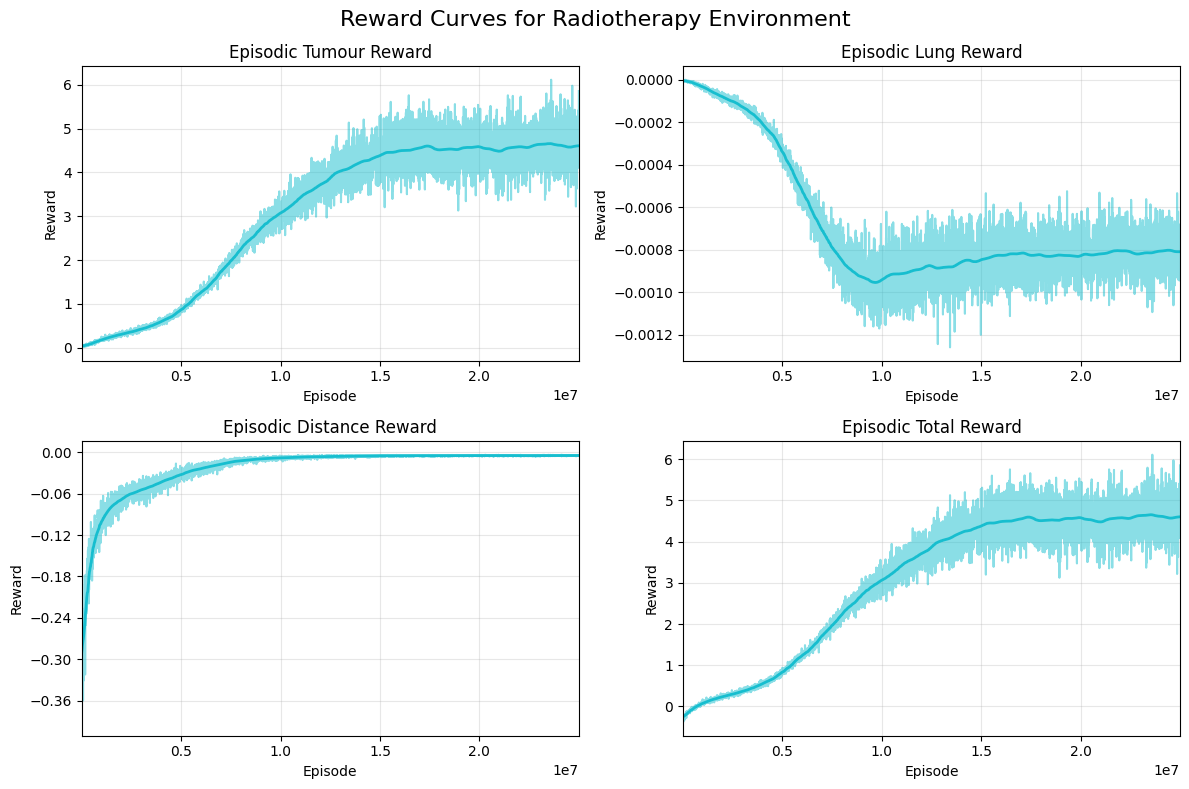

In [19]:
def plot_reward_scalar(ax, data, title):
    plot_scalar_data(ax, data, title=title, xlabel="Episode", ylabel="Reward", sigma=50)

episodic_tumour_reward = scalar_data["charts/episodic_tumour_reward"]
episodic_lung_reward = scalar_data["charts/episodic_lung_reward"]
episodic_distance_reward = scalar_data["charts/episodic_distance_reward"]
episodic_total_reward = scalar_data["charts/episodic_total_reward"]

fig, axs = plt.subplots(2, 2, figsize=(12, 8))
plot_reward_scalar(axs[0, 0], episodic_tumour_reward, "Episodic Tumour Reward")
plot_reward_scalar(axs[0, 1], episodic_lung_reward, "Episodic Lung Reward")
plot_reward_scalar(axs[1, 0], episodic_distance_reward, "Episodic Distance Reward")
plot_reward_scalar(axs[1, 1], episodic_total_reward, "Episodic Total Reward")

fig.suptitle("Reward Curves for Radiotherapy Environment", fontsize=16)

plt.tight_layout()
if save_figures:
    plt.savefig("figures/reward_curves.png", dpi=600)
else:
    plt.show()

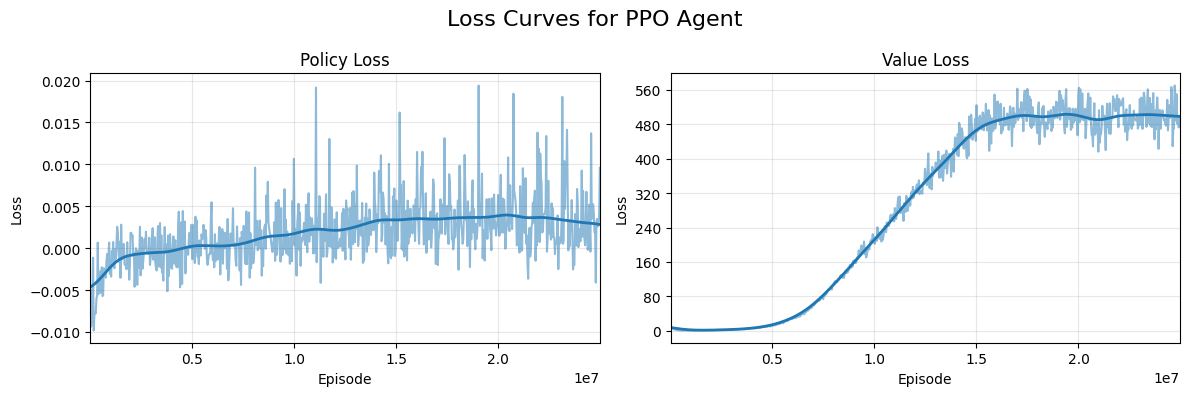

In [20]:
# loss scalars
# 'losses/value_loss', 'losses/policy_loss', 'losses/entropy', 'losses/old_approx_kl', 'losses/approx_kl', 'losses/clipfrac', 'losses/explained_variance'

def plot_loss_scalar(ax, data, title, sigma=20):
    plot_scalar_data(ax, data, title=title, xlabel="Episode", ylabel="Loss", sigma=sigma, color="#1f77b4")

value_loss = scalar_data["losses/value_loss"]
policy_loss = scalar_data["losses/policy_loss"]

fig, axs = plt.subplots(1, 2, figsize=(12, 4))
plot_loss_scalar(axs[0], policy_loss, "Policy Loss")
plot_loss_scalar(axs[1], value_loss, "Value Loss")

fig.suptitle("Loss Curves for PPO Agent", fontsize=16)

plt.tight_layout()
if save_figures:
    plt.savefig("figures/loss_curves.png", dpi=600)
else:
    plt.show()

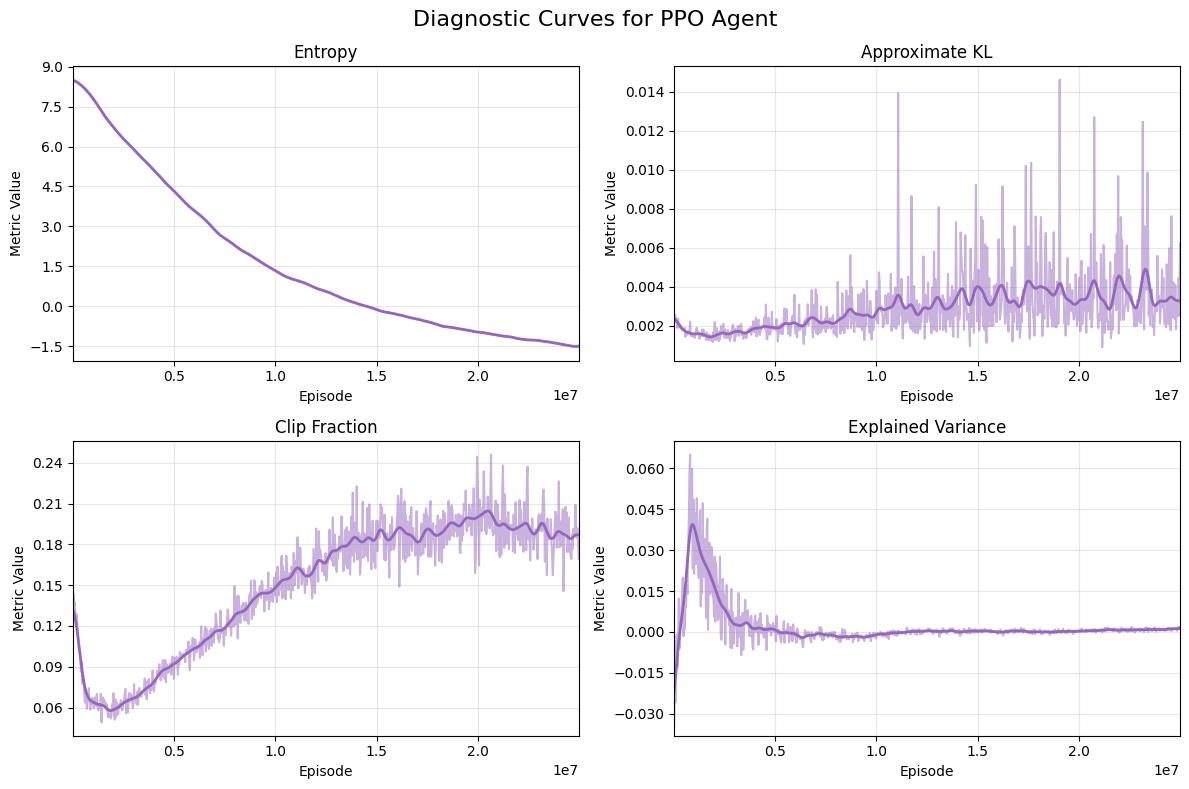

In [21]:
def plot_diagnostic_scalar(ax, data, title):
    plot_scalar_data(ax, data, title=title, xlabel="Episode", ylabel="Metric Value", sigma=5, color="#9467bd")

entropy = scalar_data["losses/entropy"]
approx_kl = scalar_data["losses/approx_kl"]
clipfrac = scalar_data["losses/clipfrac"]
explained_variance = scalar_data["losses/explained_variance"]

fig, axs = plt.subplots(2, 2, figsize=(12, 8))
plot_diagnostic_scalar(axs[0, 0], entropy, "Entropy")
plot_diagnostic_scalar(axs[0, 1], approx_kl, "Approximate KL")
plot_diagnostic_scalar(axs[1, 0], clipfrac, "Clip Fraction")
plot_diagnostic_scalar(axs[1, 1], explained_variance, "Explained Variance")

fig.suptitle("Diagnostic Curves for PPO Agent", fontsize=16)

plt.tight_layout()
if save_figures:
    plt.savefig("figures/kl_curves.png", dpi=600)
else:
    plt.show()